## Import Library

In [202]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

In [203]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [204]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        7500 non-null   object 
 1   Exercise_Duration         7500 non-null   float64
 2   Body_Temperature(F)       7500 non-null   float64
 3   BPM                       7500 non-null   float64
 4   Height(Feet)              7500 non-null   float64
 5   Height(Remainder_Inches)  7500 non-null   float64
 6   Weight(lb)                7500 non-null   float64
 7   Weight_Status             7500 non-null   object 
 8   Gender                    7500 non-null   object 
 9   Age                       7500 non-null   int64  
 10  Calories_Burned           7500 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 644.7+ KB


## Preprocessing

In [205]:
train_df['Height_Full'] = train_df['Height(Feet)'] * 12 + train_df['Height(Remainder_Inches)']
test_df['Height_Full'] = test_df['Height(Feet)'] * 12 + test_df['Height(Remainder_Inches)']
train_df.drop(columns = ['Height(Feet)', 'Height(Remainder_Inches)','ID'], inplace = True)
test_df.drop(columns = ['Height(Feet)', 'Height(Remainder_Inches)','ID'], inplace = True)

In [206]:
# BMR 기초대사량
train_df['Weight(kg)'] = train_df['Weight(lb)'] / 2.205
test_df['Weight(kg)'] = test_df['Weight(lb)'] / 2.205


train_df['BMR'] = train_df[train_df['Gender'] == 'M']['Weight(kg)']
train_df['BMR'] = train_df[train_df['Gender'] == 'F']['Weight(kg)'] * 0.9
test_df['BMR'] = test_df[test_df['Gender'] == 'M']['Weight(kg)']
test_df['BMR'] = test_df[test_df['Gender'] == 'F']['Weight(kg)'] * 0.9


# psuedo met
train_df['Max_BPM'] = 220 - train_df['Age']
test_df['Max_BPM'] = 220 - test_df['Age']
train_df['Exercise_Power'] = train_df['BPM'] / train_df['Max_BPM'] * 100 // 10
test_df['Exercise_Power'] = test_df['BPM'] / train_df['Max_BPM'] * 100//10

# psuedo calroies_burned
train_df['Exercise_Calories'] = train_df['Exercise_Power'] * 3.5 * train_df['Weight(kg)']* train_df['Exercise_Duration']
test_df['Exercise_Calories'] = test_df['Exercise_Power'] * 3.5 * test_df['Weight(kg)'] * test_df['Exercise_Duration']
train_df.head()
# drop columns
train_df.drop(columns = ['Max_BPM','Exercise_Power','Weight(lb)'], inplace = True)
test_df.drop(columns = ['Max_BPM','Exercise_Power','Weight(lb)'], inplace = True)

In [207]:
le_wei = LabelEncoder()
train_df['Weight_Status'] = le_wei.fit_transform(train_df['Weight_Status'])
test_df['Weight_Status'] = le_wei.transform(test_df['Weight_Status'])
le_gen = LabelEncoder()
train_df['Gender'] = le_gen.fit_transform(train_df['Gender'])
test_df['Gender'] = le_gen.transform(test_df['Gender'])

In [208]:
# gender_mean = train_df.groupby('Gender').mean()
# gender_mean.drop(columns = gender_mean.columns.drop('Calories_Burned'), inplace = True)
# gender_mean.rename(columns = {'Calories_Burned':'Gender_mean'}, inplace = True)

# weight_mean = train_df.groupby('Weight_Status').mean()
# weight_mean.drop(columns = weight_mean.columns.drop('Calories_Burned'), inplace = True)
# weight_mean.rename(columns = {'Calories_Burned':'Weight_mean'}, inplace = True)

# train_df = pd.merge(train_df, gender_mean, how = 'left', on = ['Gender'])
# train_df = pd.merge(train_df, weight_mean, how = 'left', on = ['Weight_Status'])
# test_df = pd.merge(test_df, gender_mean, how =  'left', on = ['Gender'])
# test_df = pd.merge(test_df, weight_mean, how = 'left', on = ['Weight_Status'])

## Visualization

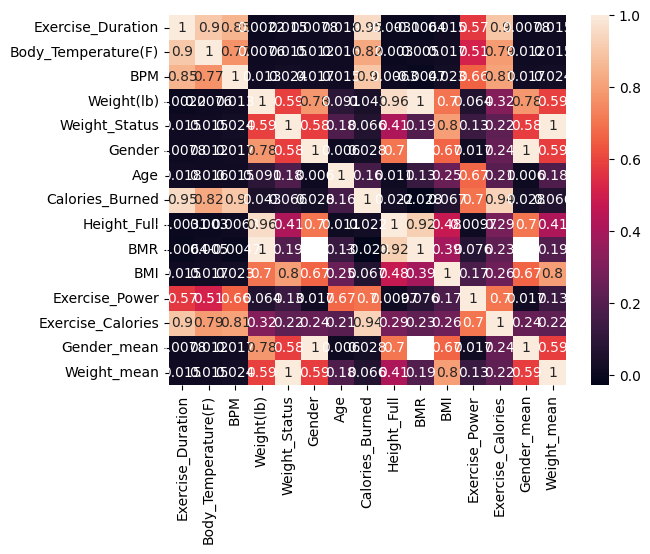

In [35]:
sns.heatmap(train_df.corr(), annot = True)
plt.show()

## MinMaxScaler

In [197]:
mm_list =[]

for idx,i in enumerate(train_df.columns):
  if i == 'Calories_Burned'  or i == 'Gender' or i == 'Weight_Status':
    continue
  mm = MinMaxScaler()
  fitted = mm.fit(train_df[i].values.reshape(-1,1))
  result = mm.transform(train_df[i].values.reshape(-1,1))
  train_df[i] = result.reshape(-1)
  mm_list.append(mm)
idx = 0
for i in test_df.columns:
  if i == 'Gender' or i == 'Weight_Status':
    continue
  result = mm_list[idx].transform(test_df[i].values.reshape(-1,1))
  test_df[i] = result.reshape(-1)
  idx +=1

## onehot

In [209]:
# Gender one_hot encoding
one_hot = OneHotEncoder(sparse = False)
train_gen_one_hot = pd.DataFrame(one_hot.fit_transform(train_df['Gender'].values.reshape(-1,1)), columns = le_gen.inverse_transform([0,1]))
test_gen_one_hot = pd.DataFrame(one_hot.transform(test_df['Gender'].values.reshape(-1,1)), columns = le_gen.inverse_transform([0,1]))

train_df.drop(columns = ['Gender'], inplace = True)
test_df.drop(columns = ['Gender'], inplace = True)

## figure

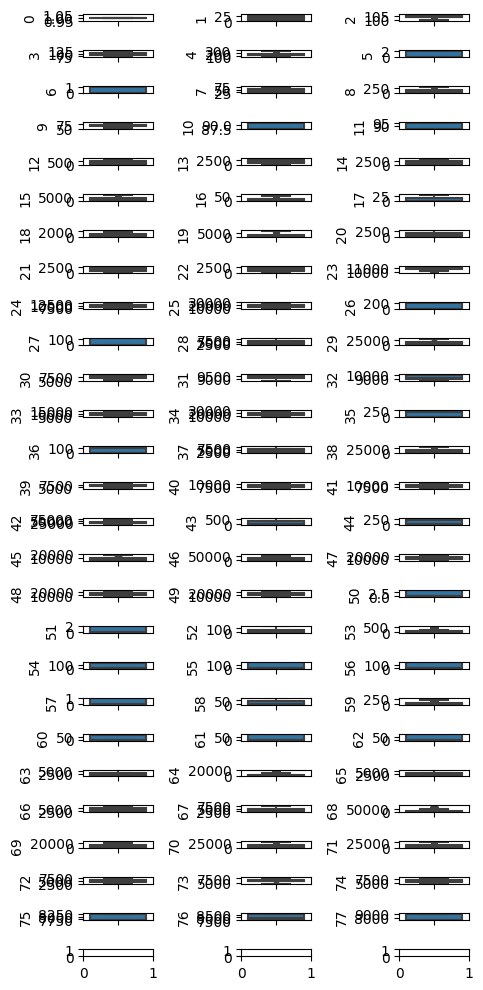

In [ ]:
fig, axes = plt.subplots(len(train_df.columns) // 3 + 1,3, figsize = (5,10))

for idx, col in enumerate(train_df.columns):
  sns.boxplot(y = train_df[col], ax = axes[idx//3][idx % 3])
plt.tight_layout()
plt.show()

In [ ]:
# body temperature은 log transformation
# bpm, height_full, weight(lb) 이상치 확인

""" IQR 처리 """
outlier_column = ['BPM','Weight(lb)','Calories_Burned']
for i in outlier_column:
  Q1 = train_df[i].quantile(0.25)
  Q3 = train_df[i].quantile(0.75)

  IQR = Q3 - Q1
  MIN = Q1 - 1.5 * IQR
  MAX = Q3 + 1.5 * IQR
  target = train_df[(train_df[i] < MIN) | (train_df[i] > MAX)]
  train_df.drop(target.index, inplace = True)
  print(f'{len(target.index)} data is outlier')
print(f'Delete the data...')

1 data is outlier
11 data is outlier
3 data is outlier
2 data is outlier
Delete the data...


## Poly features

In [199]:
poly = PolynomialFeatures(degree = 2)
poly_columns = ['Exercise_Duration','BPM']
train_poly = pd.DataFrame(poly.fit_transform(train_df[poly_columns]))
test_poly = pd.DataFrame(poly.fit_transform(test_df[poly_columns]))

train_df[train_poly.columns] = train_poly
test_df[test_poly.columns] = test_poly

train_df.drop(columns = poly_columns, inplace = True)
test_df.drop(columns = poly_columns, inplace = True)

## predict

In [37]:
!pip install autogluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.3/218.3 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [210]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label = 'Calories_Burned', eval_metric = 'rmse',problem_type = 'regression' ).fit(train_data = train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20230419_131521/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230419_131521/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    7500
Train Data Columns: 9
Label Column: Calories_Burned
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10858.75 MB
	Train Data (Original)  Memory Usage: 0.54 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitti

[1000]	valid_set's rmse: 2.00089
[2000]	valid_set's rmse: 1.73163
[3000]	valid_set's rmse: 1.62666
[4000]	valid_set's rmse: 1.57222
[5000]	valid_set's rmse: 1.54263
[6000]	valid_set's rmse: 1.52122
[7000]	valid_set's rmse: 1.50488
[8000]	valid_set's rmse: 1.494
[9000]	valid_set's rmse: 1.48624
[10000]	valid_set's rmse: 1.47683


	-1.4765	 = Validation score   (-root_mean_squared_error)
	9.88s	 = Training   runtime
	0.94s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 1.78229
[2000]	valid_set's rmse: 1.69578
[3000]	valid_set's rmse: 1.67121
[4000]	valid_set's rmse: 1.6599
[5000]	valid_set's rmse: 1.65397
[6000]	valid_set's rmse: 1.65251
[7000]	valid_set's rmse: 1.65119
[8000]	valid_set's rmse: 1.65089
[9000]	valid_set's rmse: 1.65071


	-1.6506	 = Validation score   (-root_mean_squared_error)
	11.45s	 = Training   runtime
	0.58s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-3.9904	 = Validation score   (-root_mean_squared_error)
	4.76s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost ...
	-0.7657	 = Validation score   (-root_mean_squared_error)
	81.54s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-3.2668	 = Validation score   (-root_mean_squared_error)
	4.42s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-2.2483	 = Validation score   (-root_mean_squared_error)
	6.75s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-1.912	 = Validation score   (-root_mean_squared_error)
	7.08s	 = Training   runtime
	0.49s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-3.0365	 = Validation score   (-root_mean_squared_error)
	15.35s	 = Training   runtime
	0.01s	 = Validation run

[1000]	valid_set's rmse: 2.37087
[2000]	valid_set's rmse: 2.35952
[3000]	valid_set's rmse: 2.35811
[4000]	valid_set's rmse: 2.35791
[5000]	valid_set's rmse: 2.35781
[6000]	valid_set's rmse: 2.35778
[7000]	valid_set's rmse: 2.35777
[8000]	valid_set's rmse: 2.35776
[9000]	valid_set's rmse: 2.35776
[10000]	valid_set's rmse: 2.35776


	-2.3578	 = Validation score   (-root_mean_squared_error)
	27.93s	 = Training   runtime
	1.77s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.7479	 = Validation score   (-root_mean_squared_error)
	0.32s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 184.43s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230419_131521/")


In [ ]:
# male_cnt = 0 
# female_cnt = 0
# test_df['Calories_Buned'] = [0.1 for i in range(len(test_df))]
# for idx in range(len(test_df)):
#   if test_df.loc[idx,'Gender'] == 0.0:
#     test_df.loc[idx,'Calories_Burned'] = male_pred.values[male_cnt]
#     male_cnt +=1
#   else:
#     test_df.loc[idx,'Calories_Burned'] = female_pred.values[female_cnt]
#     female_cnt += 1


In [212]:
submission = pd.read_csv('./sample_submission.csv')
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               7500 non-null   object
 1   Calories_Burned  7500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 117.3+ KB


In [213]:
y_pred = predictor.predict(test_df)

In [214]:
submission['Calories_Burned'] = y_pred
submission.to_csv('./submission.csv', index = False)
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               7500 non-null   object 
 1   Calories_Burned  7500 non-null   float32
dtypes: float32(1), object(1)
memory usage: 88.0+ KB
